In [1]:
from torch import nn

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Flatten(),
            nn.Linear(6400, 4096), nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096), nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 2)
        )

    def forward (self, X):
        x= self.model(X)
        return x

In [2]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
import numpy as np

demo = False

data_dir = './emoji/'

def read(fname):
    with open(fname, 'r') as f:
        lines = f.readlines()[1:]

    tokens = [l.rstrip().split(',') for l in lines]
    tokens = np.delete(tokens,[2,3,4,5,6,7,8,9,10,11],axis=1)

    return dict(((name.split('.')[0], label) for name, label in tokens))

In [3]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = read(os.path.join(data_dir, 'train.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)
    print('# 训练样本 :', len(labels))
    print('# 类别 :', len(set(labels.values())))

train loss 0.062, train acc 0.975
21.5 examples/sec on [device(type='cpu')]


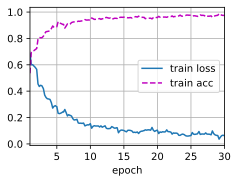

In [4]:
batch_size = 32
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                             ratio=(3.0/4.0, 4.0/3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)
print("start train")

loss = nn.CrossEntropyLoss(reduction="none")

devices, num_epochs, lr, wd = d2l.try_all_gpus(), 30, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, AlexNet()

def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
                     f' examples/sec on {str(devices)}')


net, preds = AlexNet(), []

train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())

sorted_ids = []
for value in range(3000, len(test_ds) + 3000):
    imgid = str(value) + ".jpg"
    sorted_ids.append(imgid)

df = pd.DataFrame({'image_id': sorted_ids, 'is_male': preds})
df['is_male'] = df['is_male'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)